In [1]:
from glob import glob
import SimpleITK as sitk

LUNA_DATA_PATH = '../../../data/luna16/'
LUNA_SUBSET_PATH = LUNA_DATA_PATH + 'subset0/'
OUTPUT_PATH = '../../../output/rev1/'
FILE_LIST = glob(LUNA_SUBSET_PATH + "*.mhd")

In [2]:
img_file = FILE_LIST[0] 
itk_img = sitk.ReadImage(img_file) 
print(itk_img)

Image (000001F5D7825350)
  RTTI typeinfo:   class itk::Image<short,3>
  Reference Count: 1
  Modified Time: 1060
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1035
  UpdateMTime: 1059
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 121]
  Spacing: [0.761719, 0.761719, 2.5]
  Origin: [-198.1, -195, -335.21]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.761719 0 0
0 0.761719 0
0 0 2.5

  PointToIndexMatrix: 
1.31282 0 0
0 1.31282 0
0 0 0.4

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (000001F5D9C18360)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int6

In [3]:
img_array = sitk.GetArrayFromImage(itk_img) 
print(img_array.shape)


(121, 512, 512)


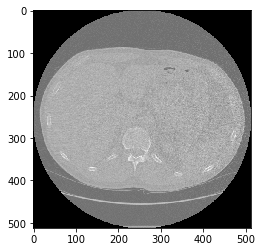

In [4]:
import pylab
pylab.imshow(img_array[0], cmap=pylab.cm.gray)  
pylab.show()

1. try to segment the way he did it and see if it worked
2. run over everything
3. find a way to disclude all the faulty examples (some code that can throw out if it doesn't work)
perform segmentation as it 

this one tells you how to process luna16:
https://www.kaggle.com/arnavkj95/data-science-bowl-2017/candidate-generation-and-luna16-preprocessing

# Luna16 Preprocessing

In [11]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import dicom
import matplotlib.pyplot as plt

DSB_DATA_PATH = '../../../data/dsb/'
STAGE1_PATH = DSB_DATA_PATH + 'stage1/'

In [12]:
def read_ct_scan(folder_name):
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        slices.sort(key=lambda x: int(x.InstanceNumber))
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices

def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [33]:
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.filters import roberts, sobel
from scipy import ndimage as ndi

def get_segmented_lungs(im, plot=False):
    binary = im < 604
    cleared = clear_border(binary)
    label_image = label(cleared)
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    selem = disk(10)
    binary = binary_closing(binary, selem)
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    return im

def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

# reduce regions of interest
def reduce_regions(ct_scan): 
    ct_scan[ct_scan < 604] = 0
    return ct_scan

# Sandbox for the Sandbox

(134, 512, 512)


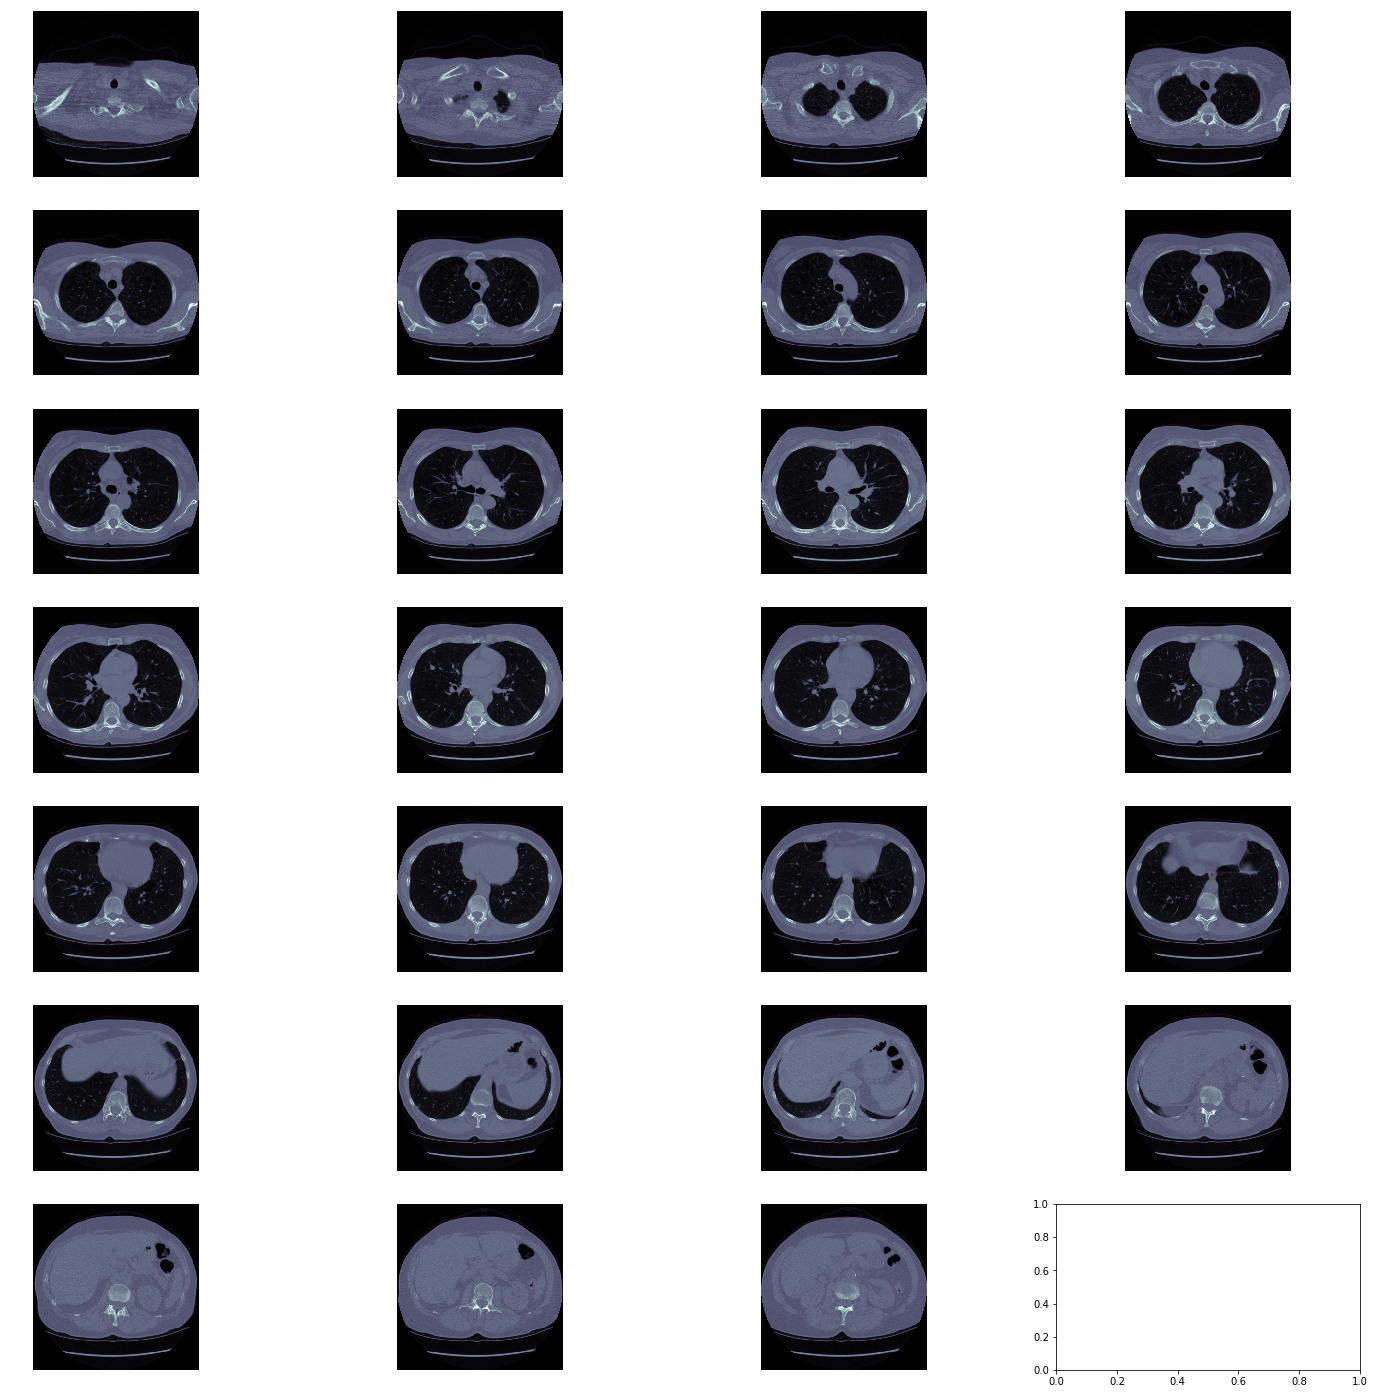

In [14]:
sample_ct_scan = read_ct_scan(STAGE1_PATH + '00cba091fa4ad62cc3200a657aeb957e/')
print(sample_ct_scan.shape)
plot_ct_scan(sample_ct_scan)

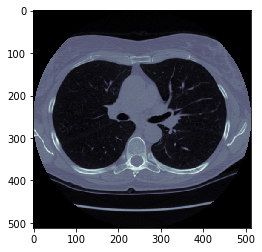

In [27]:
plt.imshow(sample_ct_scan[50], cmap=plt.cm.bone)

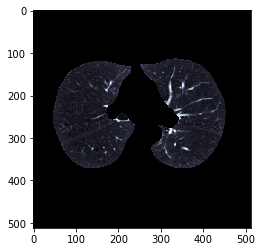

In [28]:
test = get_segmented_lungs(sample_ct_scan[50])
plt.imshow(test, cmap=plt.cm.bone)

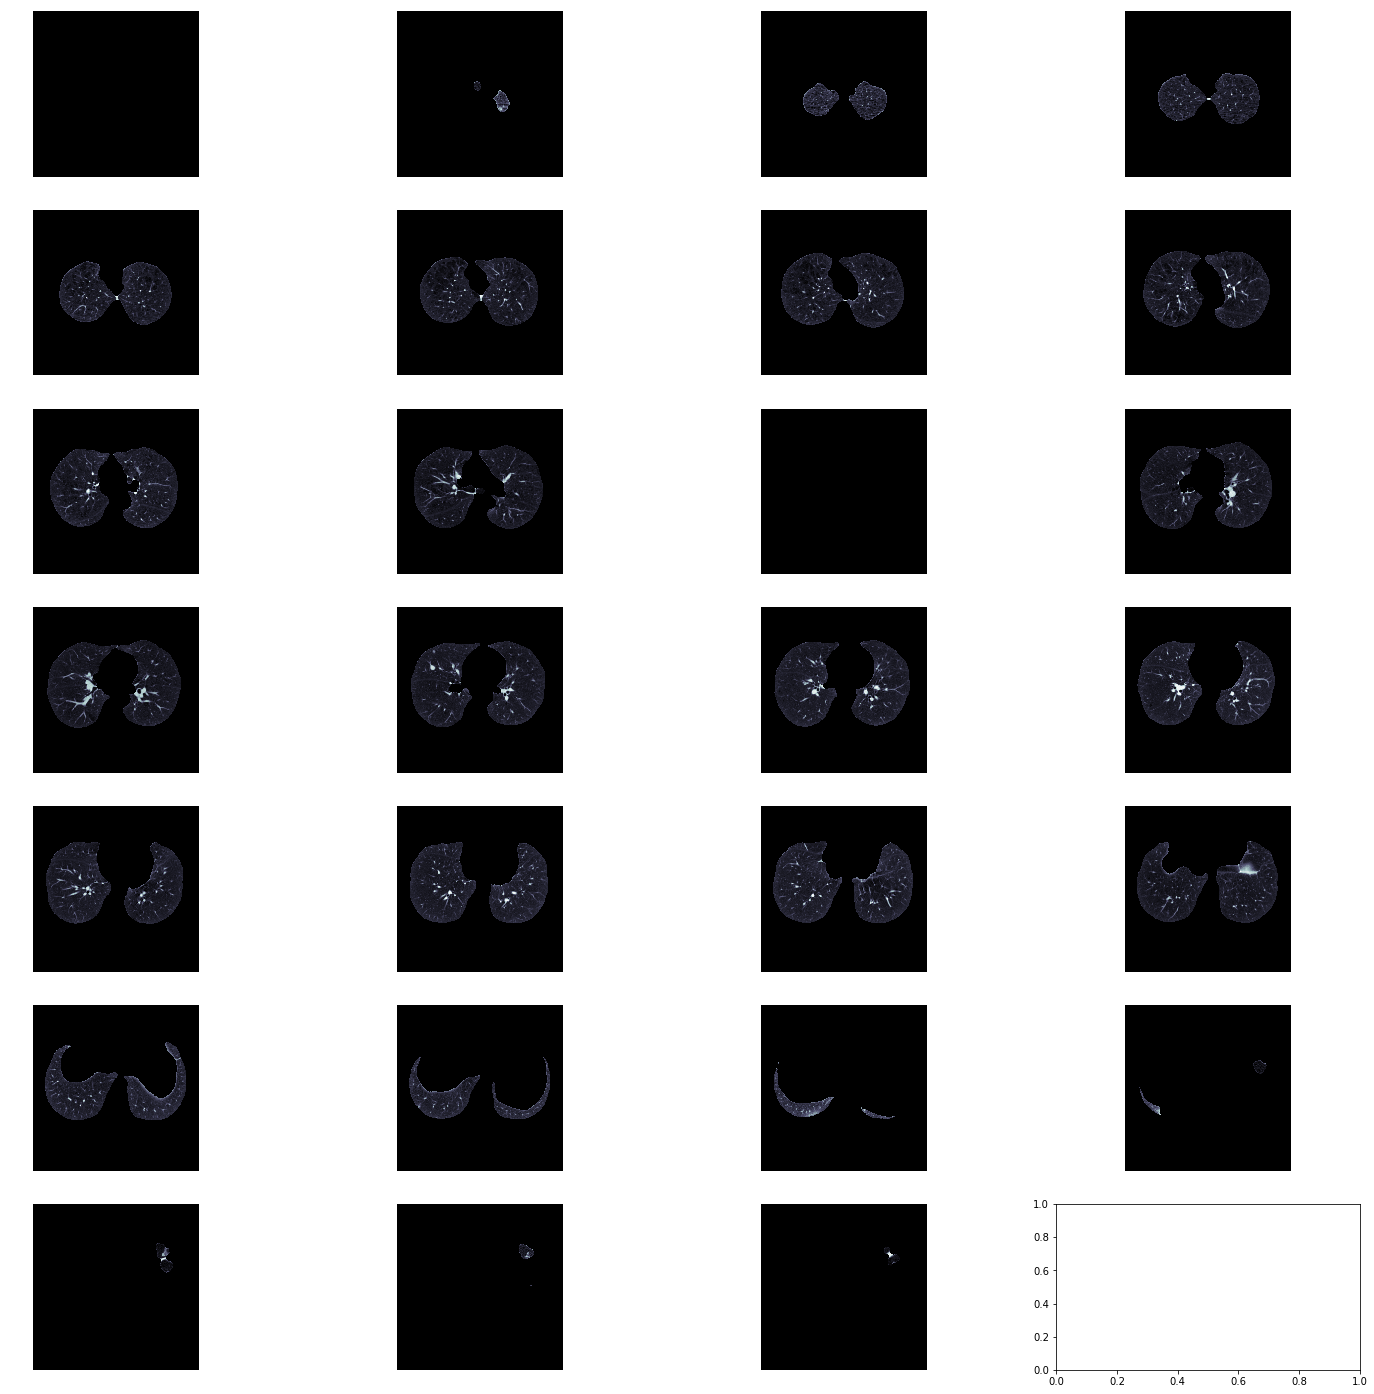

In [31]:
segmented_ct_scan = segment_lung_from_ct_scan(sample_ct_scan)
plot_ct_scan(segmented_ct_scan)

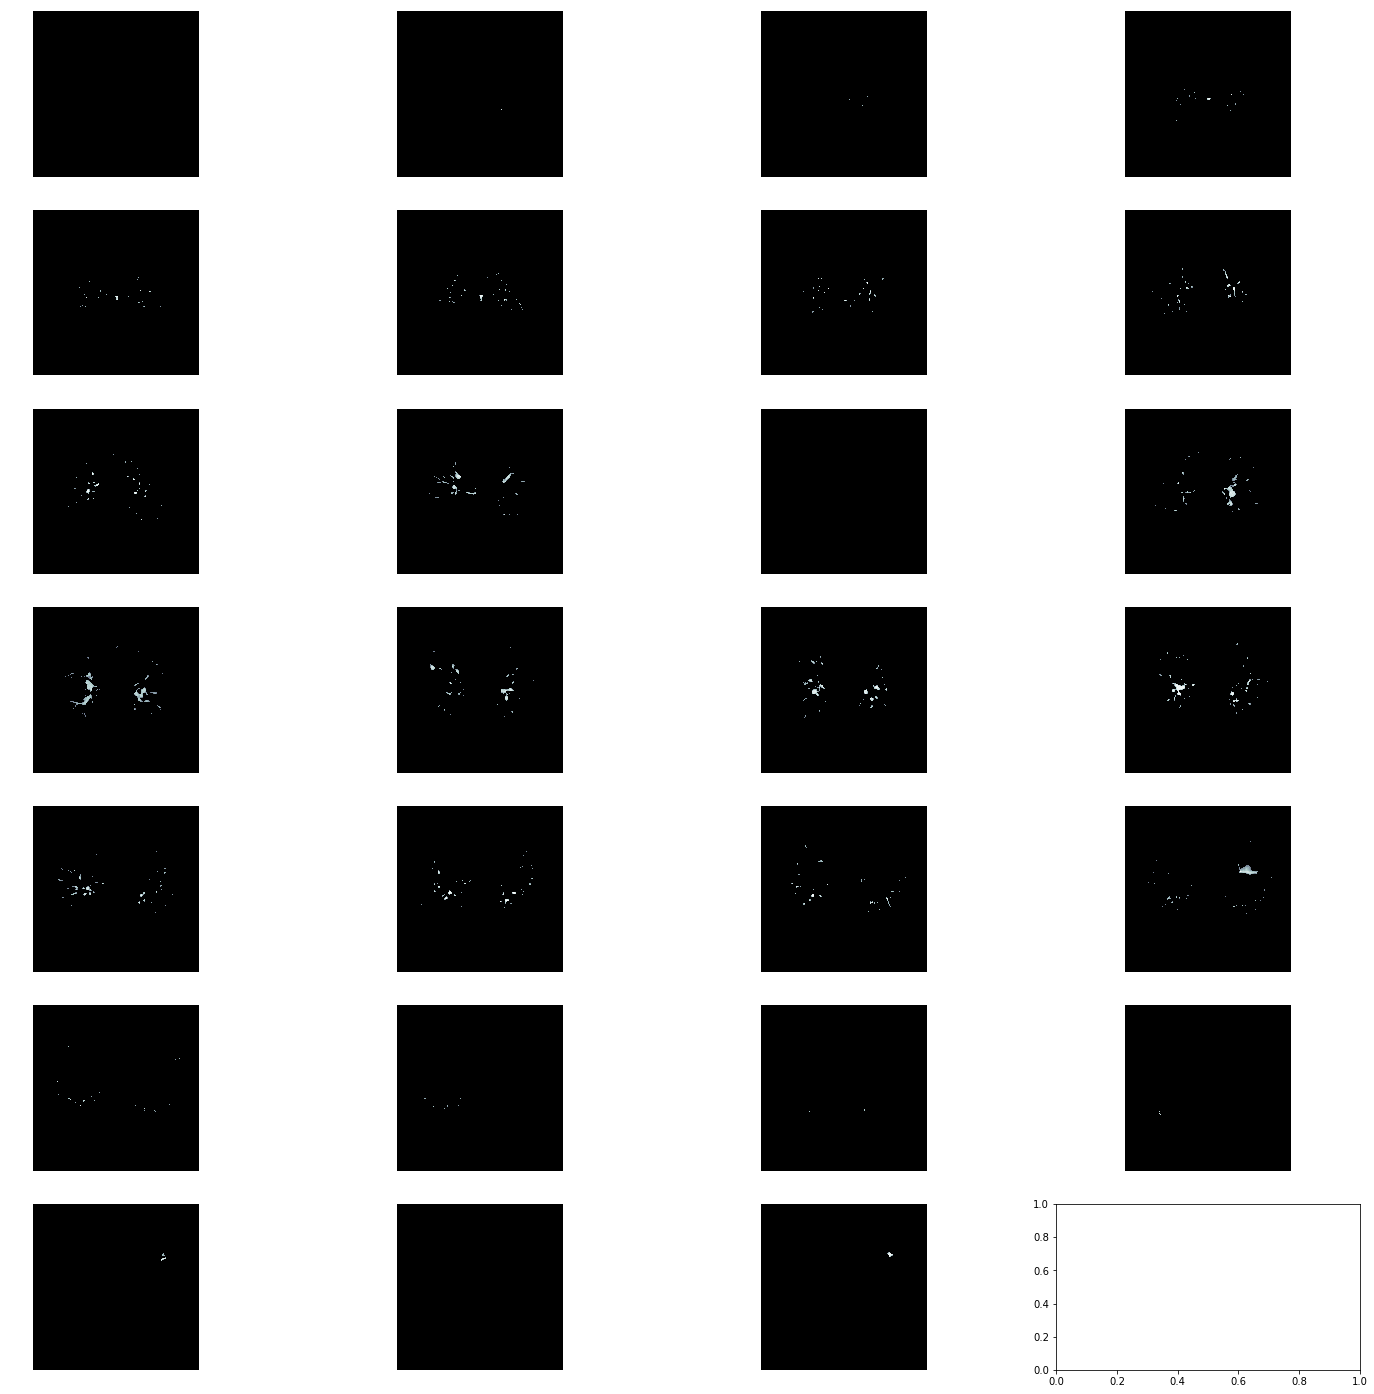

In [34]:
reduced = reduce_regions(segmented_ct_scan)
plot_ct_scan(reduced)

## Summary:
